##  ML over the graph output - Richard Henderson -  (c) TigerGraph 2020
Demo using Kaggle banksim dataset to show how ML is cheaper/faster/better with graph feeding it

This version:
     - Directly retrieves data from TigerGraph.
     - Uses simple aggregator query in TG (historical aggregates on customer, merchant and category)
     - Relies on new/improved aggregate info (with no cheating, transactions can only see their history)
     

In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import ipywidgets as widgets
# import pyTigerGraph as tg # for direct loading

In [2]:
# TG connect and load file

data_df1 = pd.read_csv("input_files/out27.csv") 

In [3]:
# Need to rename columns, and fix types, then sort it
import re

data_df = data_df1.rename(columns=lambda x: re.sub('T\.[@]?','',x),)
data_df.columns
# hmm, problem is that fraud is seen as a value, when it should be a category where 0=not fraud, and 1= fraud
cat_type = pd.CategoricalDtype(categories=[0,1])
data_df['fraud'] = data_df['fraud'].astype(cat_type)
# also id is not an integer
data_df['v_id'] = data_df['v_id'].astype(int)
data_df.sort_values("v_id", inplace=True) # Sort it to avoid overtraining
data_df #a little over a minute to run

v_id  amount fraud  step      my_cust     my_merch  \
130990       1    4.55     0     0  C1093826151   M348934600   
410044       2   39.68     0     0   C352968107   M348934600   
223897       3   26.89     0     0  C2054744914  M1823072687   
37589        4   17.25     0     0  C1760612790   M348934600   
242559       5   35.72     0     0   C757503768   M348934600   
...        ...     ...   ...   ...          ...          ...   
538748  594639   20.53     0   179  C1753498738  M1823072687   
260010  594640   50.73     0   179   C650108285  M1823072687   
501861  594641   22.44     0   179   C123623130   M349281107   
352969  594642   14.46     0   179  C1499363341  M1823072687   
334489  594643   26.93     0   179   C616528518  M1823072687   

                   my_cat  cust_sum  cust_max  cust_num_t  cust_num_f  \
130990  es_transportation      0.00      0.00           0           0   
410044  es_transportation      0.00      0.00           0           0   
223897  es_transportation      0.00      0.00           0           0   
37589   es_transportation      0.00      0.00           0           0   
242559  es_transportation      0.00      0.00           0           0   
...                   ...       ...       ...         ...         ...   
538748  es_transportation    158.03     37.27           7           0   
260010  es_transportation    157.25     58.46           7           0   
501861         es_fashion     85.00     24.83           6           0   
352969  es_transportation    206.40     71.71           7           0   
334489  es_transportation    164.87     43.49           7           0   

        merch_sum  merch_max  merch_num_t  merch_num_f   cat_sum  cat_max  \
130990        0.0       0.00            0            0       0.0     0.00   
410044        0.0       0.00            0            0       0.0     0.00   
223897        0.0       0.00            0            0       0.0     0.00   
37589         0.0       0.00            0            0       0.0     0.00   
242559        0.0       0.00            0            0       0.0     0.00   
...           ...        ...          ...          ...       ...      ...   
538748   458181.0     115.26        17072            0  595312.0   115.26   
260010   458181.0     115.26        17072            0  595312.0   115.26   
501861    11015.0     191.55          162            0   20377.5   191.55   
352969   458181.0     115.26        17072            0  595312.0   115.26   
334489   458181.0     115.26        17072            0  595312.0   115.26   

        cat_num_t  cat_num_f  
130990          0          0  
410044          0          0  
223897          0          0  
37589           0          0  
242559          0          0  
...           ...        ...  
538748      22183          0  
260010      22183          0  
501861        303          2  
352969      22183          0  
334489      22183          0  

[594643 rows x 19 columns]

In [4]:
# Data is unbalanced as we'd expect, many fewer frauds than good transactions
data_df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

### We need to run a reasonable ML such that we can score any subsequent set.
### We'll split the data-set into the relational one by selecting out only the relevant columns from the full width graph one

In [5]:
# Define the columns we care about for the two types of data, rdb/transaction only versus full graph features
target='fraud'

rdb_predictors=['amount','my_cust', 'my_merch', 'my_cat'] # these are what we get from the payment system

graph_predictors =['amount', 'my_cust', 'my_merch', 'my_cat',
       'cust_sum', 'cust_max', 'cust_num_t', 'cust_num_f', 'merch_sum', # These are our graph synthesised features
       'merch_max', 'merch_num_t', 'merch_num_f', 'cat_sum', 'cat_max',
       'cat_num_t', 'cat_num_f']

In [6]:
# Split data into train, test and validate sets, 60:20:20, with adjustment so sets don't divide days

train_location = (len(data_df)*6//10)
test_location = (len(data_df)*8//10)


step_train=data_df.iloc[train_location-1].step
step_test=data_df.iloc[train_location].step
# print ("step_train:",step_train,", step_test: ", step_test)

# wind back step_train till a different step number
while data_df.iloc[train_location-1].step == step_test :
    train_location -= 1
 
step_train=data_df.iloc[train_location-1].step
step_test=data_df.iloc[train_location].step
#print ("step_train:",step_train,", step_test: ", step_test)

# Now do same for validation set
step_test=data_df.iloc[test_location-1].step
step_valid=data_df.iloc[test_location].step
#print ("step_test:",step_test,", step_valid: ", step_valid)

# wind back step_train till a different step number
while data_df.iloc[test_location-1].step == step_valid :
    test_location -= 1
  
step_test=data_df.iloc[test_location-1].step
step_valid=data_df.iloc[test_location].step
#print ("step_test:",step_test,", step_valid: ", step_valid)

train_df = data_df[:train_location-1]
test_df = data_df[train_location:test_location-1]
valid_df = data_df[test_location:]

# New locations
#print ("test split old/new: ",len(data_df)*6//10,", ",train_location )
#print ("valid split old/new: ",len(data_df)*8//10,", ",test_location )

In [7]:
# let's check the score of a dumb classifer, it predicts everything is "Not Fraud"
from sklearn import metrics
l=pd.DataFrame(valid_df['fraud']) # extract only the fraud column
l['baseline'] =0 # add a column which is always 0 (not fraud), this will be our prediction
l['baseline'] = l['baseline'].astype(cat_type)

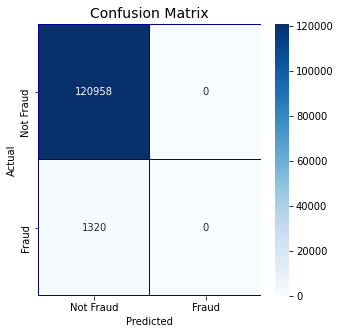

In [8]:
# plot the confusion matrix, good positive (fraud) and good negative (not fraud) are top left and bottom right
#
import matplotlib.pyplot as plt
import seaborn as sns
cm = pd.crosstab(l['fraud'], l['baseline'], rownames=['Actual'], colnames=['Predicted'], dropna=False)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, 
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### We can see above, no frauds are predicted. Bottom left is the problem.
### On to the real classification challenge.

In [9]:
# Using the catboost classifier from yandex. Easy and performs really well. Relational columns only.
from catboost import CatBoostClassifier

clf = CatBoostClassifier(eval_metric='BalancedAccuracy', od_type='Iter', metric_period=20) #, od_wait=50) 
# grab the non-numeric features
categorical_features_indices = np.where(train_df[rdb_predictors].dtypes != np.float)[0]
# run the model
rdb_model = clf.fit(train_df[rdb_predictors], train_df[target],cat_features=categorical_features_indices,
                    eval_set=(test_df[rdb_predictors], test_df[target]),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.135021


0:	learn: 0.8363430	test: 0.8447010	best: 0.8447010 (0)	total: 216ms	remaining: 3m 36s
20:	learn: 0.8956624	test: 0.8815243	best: 0.8837800 (19)	total: 2.1s	remaining: 1m 37s
40:	learn: 0.9092761	test: 0.8860059	best: 0.8875594 (30)	total: 3.84s	remaining: 1m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8875593834
bestIteration = 30

Shrink model to first 31 iterations.


Predicted       0  1
Actual              
0          120958  0
1            1320  0
Predicted       0    1
Actual                
0          120888   70
1             326  994


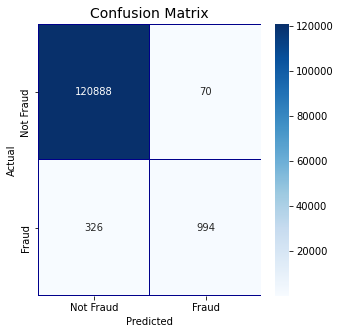

In [10]:
# Lets see the results by running the generated model against the validation set.
import matplotlib.pyplot as plt
import seaborn as sns

# So now we need to test the model against the validator
preds = clf.predict(valid_df[rdb_predictors]) 

cm1 = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'], dropna=False)
print (cm)
print(cm1)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm1, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

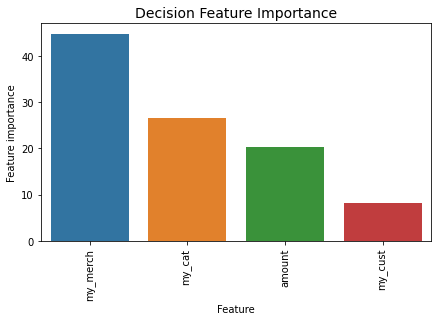

In [11]:
# What were the significant features in the model?
tmp = pd.DataFrame({'Feature': rdb_predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Decision Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [12]:
# run the same classifier against the graph contextual columns
categorical_features_indices = np.where(train_df[graph_predictors].dtypes != np.float)[0]

clf2 = CatBoostClassifier(eval_metric='BalancedAccuracy', od_type='Iter', metric_period=20) 

clf2.fit(train_df[graph_predictors], train_df[target],cat_features=categorical_features_indices,
         eval_set=(test_df[graph_predictors], test_df[target]),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.135021


0:	learn: 0.9015784	test: 0.8903216	best: 0.8903216 (0)	total: 224ms	remaining: 3m 43s
20:	learn: 0.9450244	test: 0.9422539	best: 0.9422624 (18)	total: 5.19s	remaining: 4m 1s
40:	learn: 0.9541682	test: 0.9426284	best: 0.9452799 (29)	total: 10.7s	remaining: 4m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9452799377
bestIteration = 29

Shrink model to first 30 iterations.


Predicted       0  1
Actual              
0          120958  0
1            1320  0
Predicted       0    1
Actual                
0          120888   70
1             326  994
Predicted       0     1
Actual                 
0          120925    33
1             162  1158


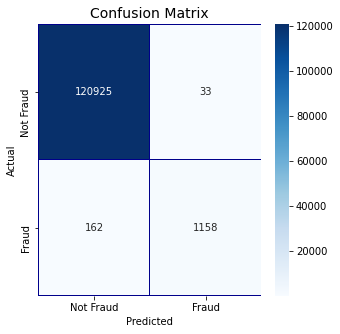

In [13]:
# So now we need to test the new model against the validation set and look at the results
preds = clf2.predict(valid_df[graph_predictors]) 
import matplotlib.pyplot as plt
import seaborn as sns
cm2 = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'], dropna=False)
print (cm)
print(cm1)
print(cm2)
fig, (ax2) = plt.subplots(ncols=1, figsize=(5,5))
ax2 = sns.heatmap(cm2, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

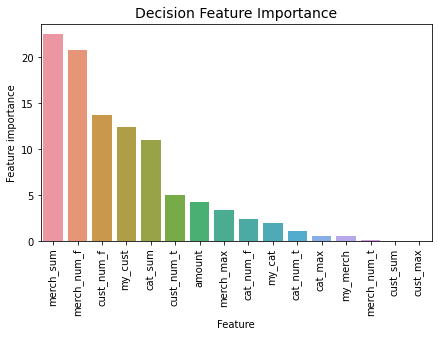

In [14]:
# Looks better. A lot better. And the most significant features:
tmp = pd.DataFrame({'Feature': graph_predictors, 'Feature importance': clf2.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Decision Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 